In [114]:
import pandas as pd

In [115]:
news = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", index_col = 0)
news.shape

(250, 15)

In [116]:
news.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


In [117]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                250 non-null    int64  
 1   domain            250 non-null    object 
 2   type              238 non-null    object 
 3   url               250 non-null    object 
 4   content           250 non-null    object 
 5   scraped_at        250 non-null    object 
 6   inserted_at       250 non-null    object 
 7   updated_at        250 non-null    object 
 8   title             250 non-null    object 
 9   authors           170 non-null    object 
 10  keywords          0 non-null      float64
 11  meta_keywords     250 non-null    object 
 12  meta_description  54 non-null     object 
 13  tags              27 non-null     object 
 14  summary           0 non-null      float64
dtypes: float64(2), int64(1), object(12)
memory usage: 31.2+ KB


In [118]:
news.groupby('type').size().sort_values(ascending = False)

type
fake          155
conspiracy     31
political      23
unreliable      6
unknown         6
junksci         6
bias            6
reliable        3
hate            1
clickbait       1
dtype: int64

In [119]:
# some news may same
news.drop_duplicates('content', 'first', inplace = True)
news.groupby('type').size().sort_values(ascending = False)

type
fake          146
conspiracy     31
political      22
unreliable      6
unknown         6
bias            6
junksci         5
reliable        3
hate            1
clickbait       1
dtype: int64

In [120]:
news.columns

Index(['id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at',
       'updated_at', 'title', 'authors', 'keywords', 'meta_keywords',
       'meta_description', 'tags', 'summary'],
      dtype='object')

In [126]:
df = pd.DataFrame(news, columns = ['id', 'type', 'content', 'title', 'domain'])
df.head()

,id,type,content,title,domain
0,141,unreliable,Sometimes the power of Christmas will make you...,Church Congregation Brings Gift to Waitresses ...,awm.com
1,256,fake,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,beforeitsnews.com
2,700,unreliable,Never Hike Alone: A Friday the 13th Fan Film U...,Never Hike Alone - A Friday the 13th Fan Film ...,cnnnext.com
3,768,unreliable,"When a rare shark was caught, scientists were ...",Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,awm.com
4,791,clickbait,Donald Trump has the unnerving ability to abil...,Trump’s Genius Poll Is Complete & The Results ...,bipartisanreport.com


In [127]:
df.isnull().sum()

id          0
type       12
content     0
title       0
domain      0
dtype: int64

In [128]:
df = df.dropna()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of articles by type')

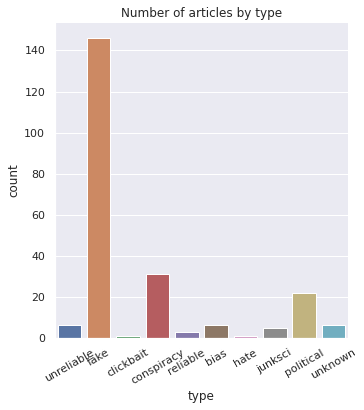

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
type_plot = sns.catplot('type', data = df, kind = 'count')
(type_plot.set_xticklabels(rotation=30)
          .ax.set_title('Number of articles by type'))

In [130]:
# Some types of samples are insufficient, merge labels
df['type'].replace(
    ['conspiracy', 'bias', 'junksci', 'rumor', 'satire', 'hate', 'unreliable', 'fake'], 'fake', inplace = True)
df['type'].replace(
    ['reliable', 'political'], 'truth', inplace = True)
df['type'].replace(
    ['clickbait', 'unknown'], 'others', inplace = True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of articles by merged type')

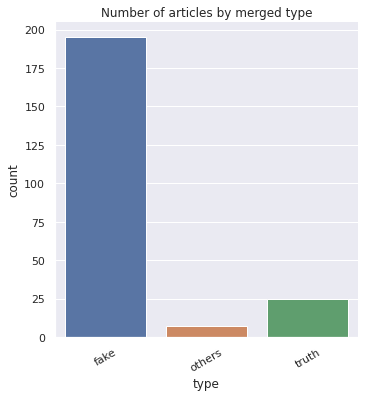

In [131]:
type_plot2 = sns.catplot('type', data = df, kind = 'count')
(type_plot2.set_xticklabels(rotation=30)
          .ax.set_title('Number of articles by merged type'))

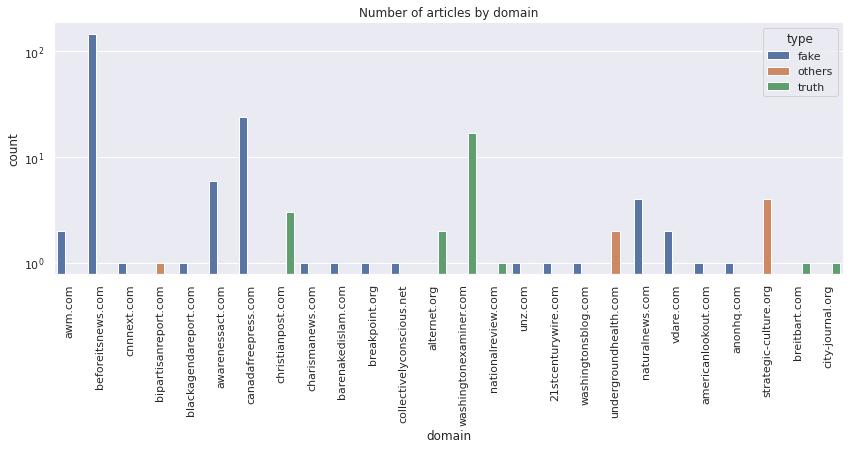

In [155]:
domain_plot = sns.catplot(x="domain", hue="type", data=df, kind="count", legend_out=False)
(domain_plot.set_xticklabels(rotation = 90)
            .set(yscale = "log")
            .set(title = 'Number of articles by domain')
            .fig.set_size_inches(15,4))

In [72]:
import re
from nltk.tokenize import RegexpTokenizer

In [87]:
def clean(text):
    #Remove URLs
    text = re.sub(r'http\S+', '', text)
    #lower texts
    text = re.sub(r'[^\w\s]', '', text).lower()
    tokenizer = RegexpTokenizer('\w+[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #only keep vocabulary
    voc = [i for i in tokens if i.isalpha()]    
    return voc

In [164]:
df['content'] = df.apply(lambda x: clean(x['content']), axis=1)
df['title'] = df.apply(lambda x: clean(x['title']), axis=1)

In [165]:
df.head()

,id,type,content,title,domain
0,141,fake,"[sometimes, the, power, of, christmas, will, m...","[church, congregation, brings, gift, to, waitr...",awm.com
1,256,fake,"[awakening, of, strands, of, dna, reconnecting...","[awakening, of, strands, of, dna, reconnecting...",beforeitsnews.com
2,700,fake,"[never, hike, alone, a, friday, the, th, fan, ...","[never, hike, alone, a, friday, the, th, fan, ...",cnnnext.com
3,768,fake,"[when, a, rare, shark, was, caught, scientists...","[elusive, alien, of, the, sea, caught, by, sci...",awm.com
4,791,others,"[donald, trump, has, the, unnerving, ability, ...","[trumps, genius, poll, is, complete, the, resu...",bipartisanreport.com
